In [1]:
## ssh -t -t seb300@o2.hms.harvard.edu -L 8886:localhost:8886 ssh $NODE_ID -L 8886:localhost:8886

In [1]:
import pandas as pd
import json
import os

data = {}
name = {}
for path, directories, files in os.walk('.'):
    if "_trial_learnability" in path:
        for file in files:
            if "json" in file:
                grid = path.split("_")[-4]
                ghost = "_".join(path.split("_")[-3:-1])
                if grid not in data:
                    data[grid] = {}
                    name[grid] = {}
                if ghost not in data[grid]:
                    data[grid][ghost] = []
                    name[grid][ghost] = []
                with open(os.path.join(path, file)) as f:
                    print(f"reading filename {os.path.join(path, file)}\n")
                    data[grid][ghost].append(json.load(f))
                    name[grid][ghost].append("_".join(path.split("_")[-2:]))


reading filename ./_trial_learnability_BoltzmannAgent_v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}/saved_agent_BoltzmannAgent_v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}_1-17552-16:11:2023-00:18:09-train0_training_agent.json

reading filename ./_trial_learnability_BoltzmannAgent_v2_DirectionalGhost_{"index":1,"prob":0.6}_{"mean":0,"std":0.1}/saved_agent_BoltzmannAgent_v2_DirectionalGhost_{"index":1,"prob":0.6}_{"mean":0,"std":0.1}_1-11963-14:11:2023-11:10:00-train0_training_agent.json

reading filename ./_trial_learnability_BoltzmannAgent_v2_DirectionalGhost_{"index":1,"prob":0.3}_{"mean":0,"std":0}/saved_agent_BoltzmannAgent_v2_DirectionalGhost_{"index":1,"prob":0.3}_{"mean":0,"std":0}_1-20954-16:11:2023-00:22:13-train0_training_agent.json

reading filename ./_trial_learnability_BoltzmannAgent_v3_DirectionalGhost_{"index":1,"prob":0.6}_{"mean":0,"std":0.1}/saved_agent_BoltzmannAgent_v3_DirectionalGhost_{"index":1,"prob":0.6}_{"mean":0,"std":0.1}_1-31187-14:1

In [2]:
grid=list(data.keys())[1]
ghost=list(data[grid].keys())[1]
nois_df = pd.DataFrame(data[grid][ghost], index=name[grid][ghost])

In [3]:
color_maps=['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
             'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
             'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
             'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
             'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
             'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
             'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
             'ylorrd']

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns

In [5]:
cmp = 'algae'
def correlation_heatmap(y_cols, x_cols, full_data):
    '''
    Uses scipy.stats.spearmanr function
    Params:
    y_cols, x_cols: sets of column titles (strings)
    full_data: pandas dataframe that includes all columns listed in y_cols, x_cols
    Returns:
    corr: Spearman correlation coefficient matrix (y_cols = rows, x_cols = cols of matrix)
    fig_corr: annotated plotly heatmap of coefficients
    p: Spearman p-value matrix
    fig_p: annotated plotly heatmap of p-values
    '''
    cols = y_cols+x_cols
    all_correlations = scipy.stats.spearmanr(full_data[cols], nan_policy='omit')
    corr = all_correlations.statistic[:len(y_cols), -len(x_cols):]
    corr = pd.DataFrame(corr)
    corr.columns = x_cols
    corr.index = y_cols

    p = all_correlations.pvalue[:len(y_cols), -len(x_cols):]
    p = pd.DataFrame(p)
    p.columns = x_cols
    p.index = y_cols
    
    fig_corr = px.imshow(corr, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_r2 = px.imshow(corr**2, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_p = px.imshow(p, text_auto=True, aspect='auto', color_continuous_scale='gray_r')

    return corr, fig_corr, p, fig_p, fig_r2

In [6]:
def correlation(df_final):
    corr, fig_corr, p, fig_p, fig_r2 = correlation_heatmap(col_1, col_2, df_final)
    fig_corr.show()
    fig_p.show()
    fig_r2.show()
    return corr, fig_corr, p, fig_p, fig_r2

In [12]:
action_pd_noise

,%%%%%%%%%%%\n%%%G .%\n%%% %%%P%%%\n%%% %%% %%%\n%%% %%% %%%\n%. %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% G P .%\n%%% %%% %%%\n%%% %%% %%%\n%%% %%% %%%\n%. %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% G .%\n%%% %%%P%%%\n%%% %%% %%%\n%%% %%% %%%\n%. %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% GP .%\n%%% %%% %%%\n%%% %%% %%%\n%%% %%% %%%\n%. %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% G P.%\n%%% %%% %%%\n%%% %%% %%%\n%%% %%% %%%\n%. %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% G .%\n%%% %%% %%%\n%%% %%% %%%\n%%% %%% %%%\n%. %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% .%\n%%%G%%% %%%\n%%% %%%P%%%\n%%% %%% %%%\n%. %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% .%\n%%% %%% %%%\n%%%G%%% %%%\n%%% %%%P%%%\n%. %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% .%\n%%% %%% %%%\n%%% %%% %%%\n%%%G%%% %%%\n%. P%%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% .%\n%%% %%% %%%\n%%% %%% %%%\n%%% %%% %%%\n%. G P %%%\n%%%%%%%%%%%,...,%%%%%%%%%%%\n%%% G P%\n%%% %%% %%%\n%%% %%% %%%\n%%% %%% %%%\n% %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% P%\n%%% %%% %%%\n%%%G%%% %%%\n%%% %%% %%%\n%. %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% G .%\n%%% %%% %%%\n%%% %%% %%%\n%%% %%% %%%\n%P %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% %\n%%% %%% %%%\n%%% %%% %%%\n%%% %%%G%%%\n%P %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% %\n%%% %%% %%%\n%%% %%% %%%\n%%% %%% %%%\n%P G %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% P%\n%%%G%%% %%%\n%%% %%% %%%\n%%% %%% %%%\n% %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% P%\n%%% %%% %%%\n%%% %%% %%%\n%%%G%%% %%%\n% %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% %\n%%% %%% %%%\n%%% %%% %%%\n%%%G%%% %%%\n%P %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% P%\n%%% %%% %%%\n%%% %%% %%%\n%%% %%% %%%\n%. G %%%\n%%%%%%%%%%%,%%%%%%%%%%%\n%%% .%\n%%% %%% %%%\n%%% %%% %%%\n%%% %%% %%%\n%P G%%%\n%%%%%%%%%%%
0,-49.628514,NaN,-39.671255,NaN,NaN,NaN,-45.37171,-25.150753,-25.050000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-29.408658,-8.729579,-16.420519,-29.199878,NaN,NaN,-53.76651,-4.592769,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,-36.466825,NaN,-58.425111,-26.446792,NaN,NaN,NaN,NaN,-23.054822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,-37.648844,NaN,-71.455125,-20.380944,NaN,NaN,NaN,-24.424696,-4.806269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


exploring grid: v2 w/ ghost RandomGhost_{"index":1,"prob":{}}, noise-no_noise


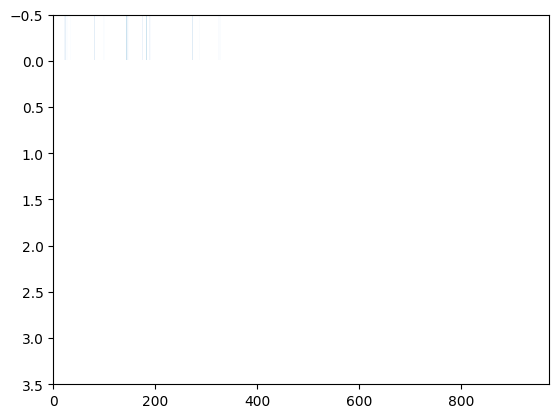

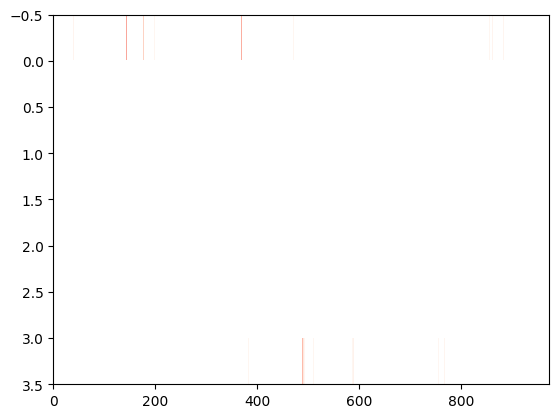

exploring grid: v2 w/ ghost DirectionalGhost_{"index":1,"prob":0.6}, noise-no_noise


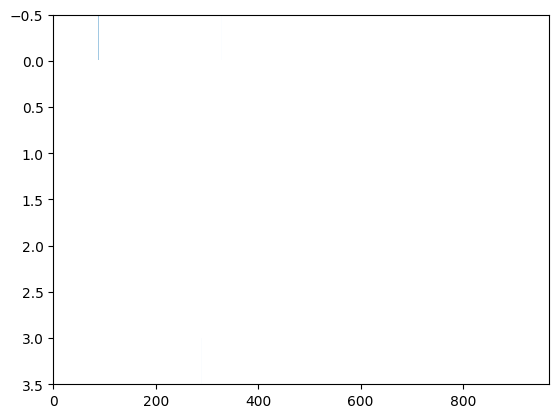

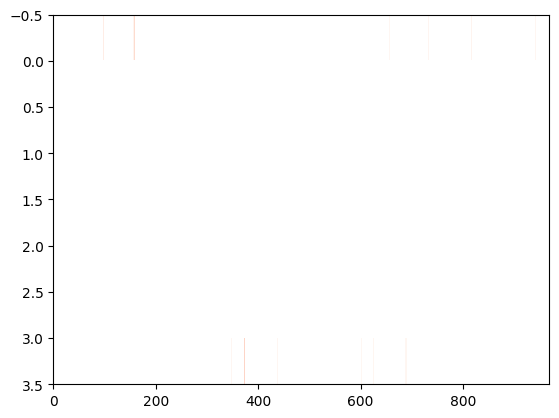

exploring grid: v2 w/ ghost DirectionalGhost_{"index":1,"prob":0.3}, noise-no_noise


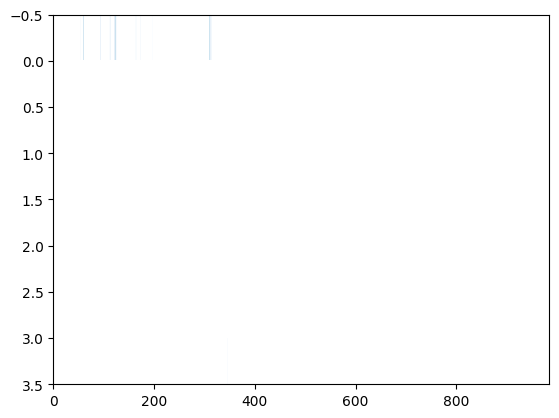

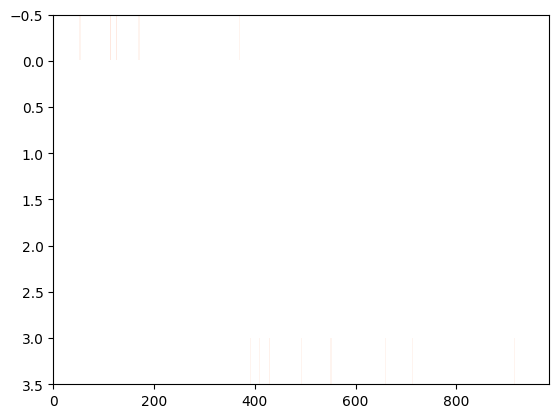

exploring grid: v3 w/ ghost DirectionalGhost_{"index":1,"prob":0.6}, noise-no_noise


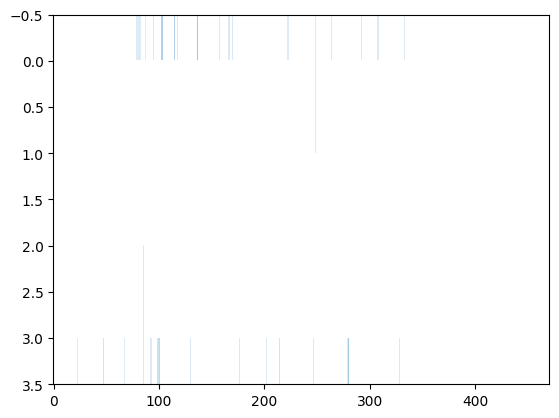

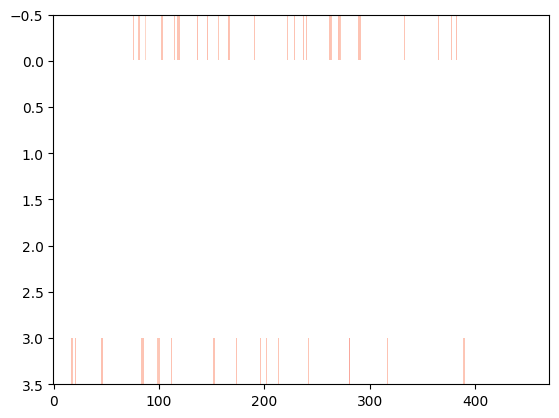

exploring grid: v3 w/ ghost DirectionalGhost_{"index":1,"prob":0.3}, noise-no_noise


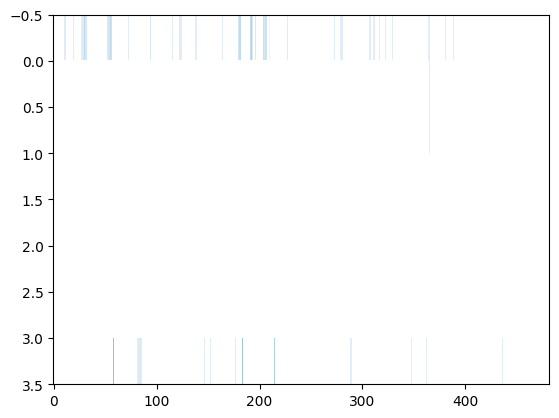

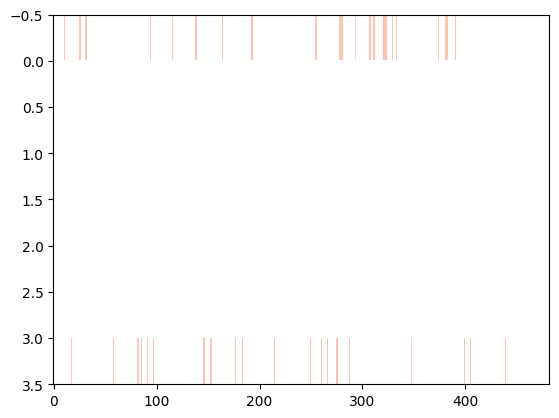

exploring grid: v3 w/ ghost RandomGhost_{"index":1,"prob":{}}, noise-no_noise


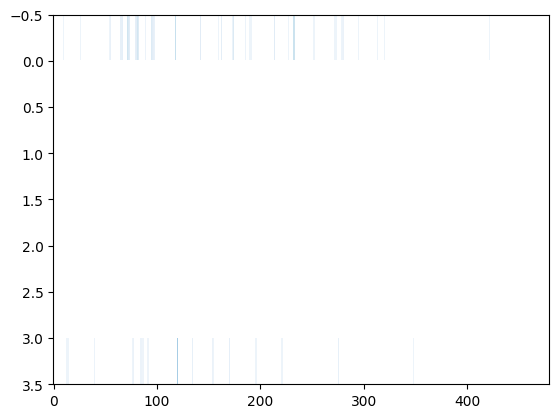

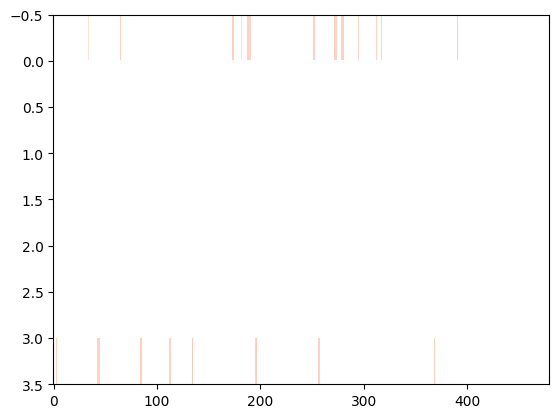

exploring grid: v4 w/ ghost DirectionalGhost_{"index":1,"prob":0.3}, noise-no_noise


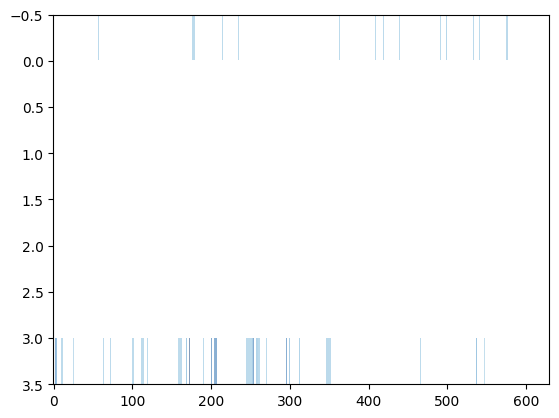

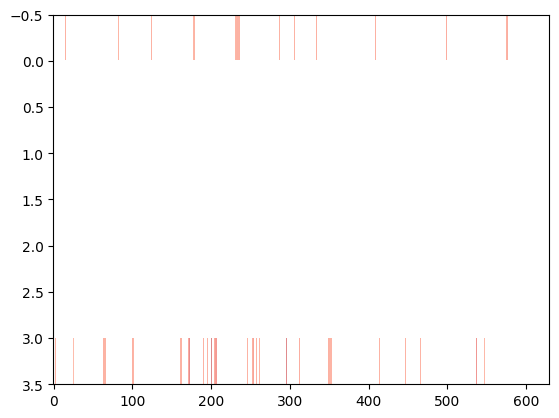

exploring grid: v4 w/ ghost RandomGhost_{"index":1,"prob":{}}, noise-no_noise


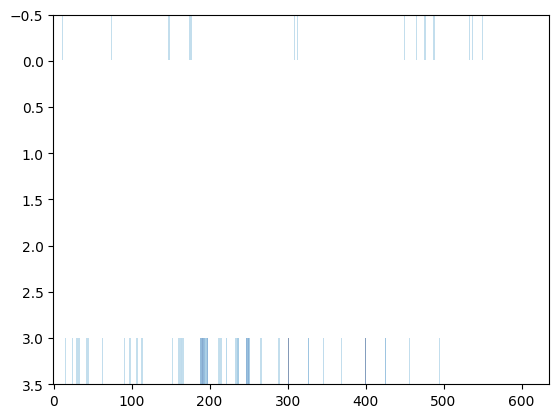

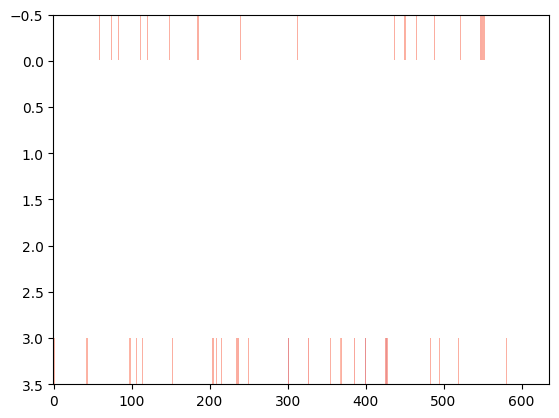

exploring grid: v4 w/ ghost DirectionalGhost_{"index":1,"prob":0.6}, noise-no_noise


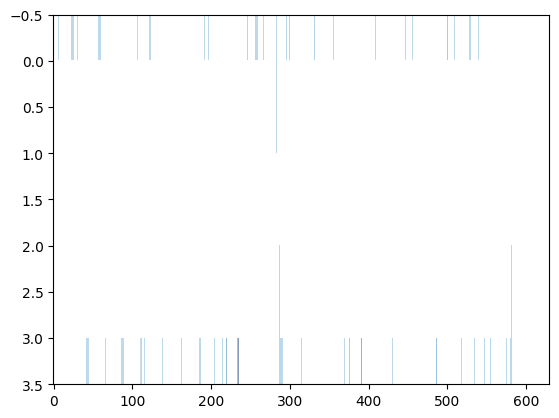

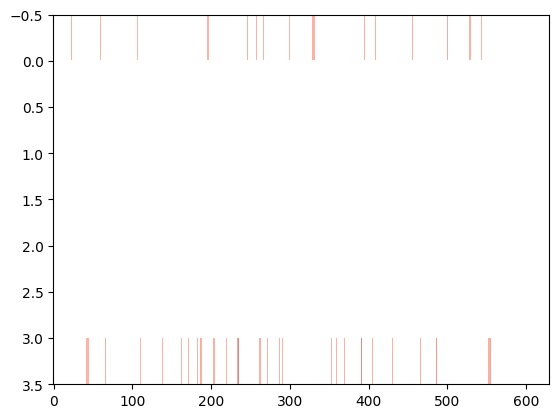

In [9]:
ax = plt.axes()
for grid in data.keys():
    for ghost in data[grid].keys():
        print(f"exploring grid: {grid} w/ ghost {ghost}, noise-no_noise")
        actions = len(pd.DataFrame(data[grid][ghost]).stack().apply(pd.Series).columns)
        action_pd_no_noise = pd.DataFrame(data[grid][ghost],index=name[grid][ghost]).T.filter(like='{"mean":0,"std":0}').T.stack().apply(pd.Series).T.iloc[["0","1","2","3"]]
        action_pd_no_noise.columns = action_pd_no_noise.columns.droplevel()
        action_pd_noise = pd.DataFrame(data[grid][ghost],index=name[grid][ghost]).T.filter(like='{"mean":0,"std":0.1}').T.stack().apply(pd.Series).T.iloc[["0","1","2","3"]]
        action_pd_noise.columns = action_pd_noise.columns.droplevel()
        merge = pd.merge(action_pd_no_noise, action_pd_noise, how='outer')
        plt.imshow(merge[merge.iloc[:4,] == merge.iloc[:4,].max()].iloc[:4,].to_numpy(), aspect="auto", cmap='Blues', alpha=0.5) # I would add interpolation='none'
        plt.show()
        plt.imshow(merge[merge.iloc[4:,] == merge.iloc[4:,].max()].iloc[4:,:], aspect="auto", cmap='Reds', alpha=0.5)
        plt.show()

In [12]:
actions = len(pd.DataFrame(data[grid][ghost]).stack().apply(pd.Series).columns)
action_pd_no_noise =pd.DataFrame(data[grid][ghost],index=name[grid][ghost]).T.filter(like='{"mean":0,"std":0}').T.stack().apply(pd.Series).T.iloc[["0","1","2","3"]]
action_pd_no_noise.columns = action_pd_no_noise.columns.droplevel()
actions = len(pd.DataFrame(data[grid][ghost]).stack().apply(pd.Series).columns)

exploring grid: v2 w/ ghost RandomGhost_{"index":1,"prob":{}}, noise-no_noise


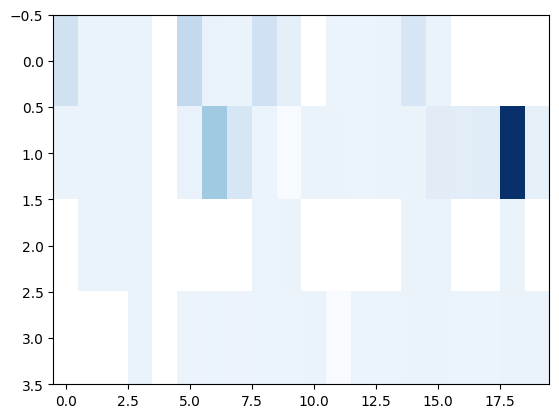

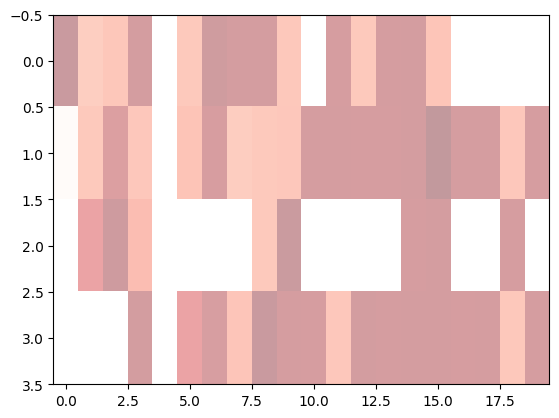

         0          1          2          3    4           5           6    \
0  50.058342  27.870239  24.782547   0.273525  NaN  101.665315    1.150067   
1  50.964622  25.611846   2.819647  25.050000  NaN   25.961838  120.534634   
2        NaN   9.780892  -1.624048  21.072611  NaN         NaN         NaN   
3        NaN        NaN        NaN  -0.003713  NaN    7.254338   -0.881388   

         7          8          9    ...  964  965  966  967  968  969  970  \
0   0.213339  53.749223  34.051736  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  65.597562  24.478120   0.000000  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2        NaN  24.262316  -3.043795  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  21.682026  -4.574654  -0.699382  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   971  972  973  
0  NaN  NaN  NaN  
1  NaN  NaN  NaN  
2  NaN  NaN  NaN  
3  NaN  NaN  NaN  

[4 rows x 974 columns]


/tmp/ipykernel_18158/4271188735.py:18: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



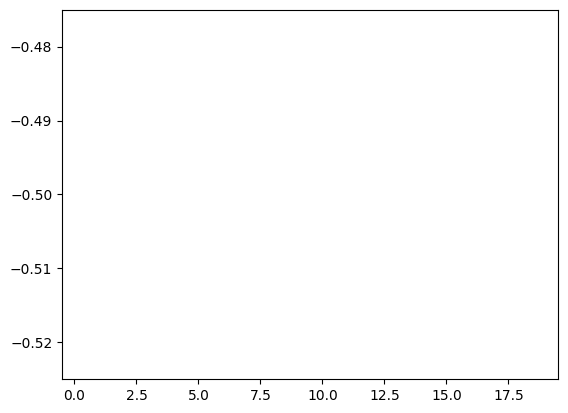

exploring grid: v2 w/ ghost DirectionalGhost_{"index":1,"prob":0.6}, noise-no_noise


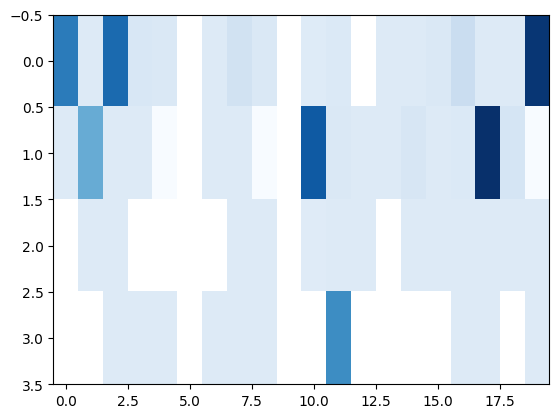

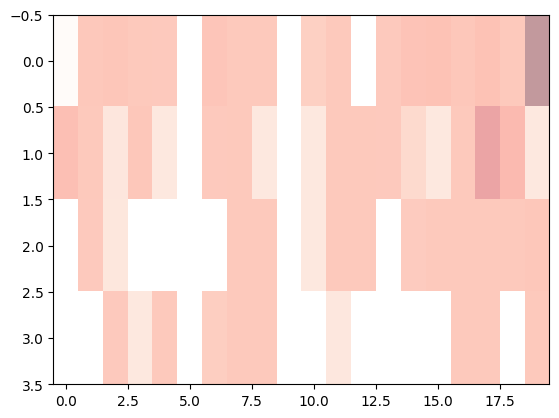

          0          1           2          3         4    5         6    \
0  157.046503  -1.302897  119.731364   4.792083  3.023946  NaN -2.423999   
1   -6.974333  72.526049   23.577022  -2.127915  0.000000  NaN  0.906199   
2         NaN  -0.530365   23.697563        NaN       NaN  NaN       NaN   
3         NaN        NaN    0.234716  24.472864 -0.367768  NaN  4.218982   

         7         8    9    ...  959  960  961  962  963  964  965  966  967  \
0  11.668361  1.781374  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  -0.036758  0.000000  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2   0.047500  0.027241  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  -0.088585  0.157023  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   968  
0  NaN  
1  NaN  
2  NaN  
3  NaN  

[4 rows x 969 columns]


/tmp/ipykernel_18158/4271188735.py:18: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



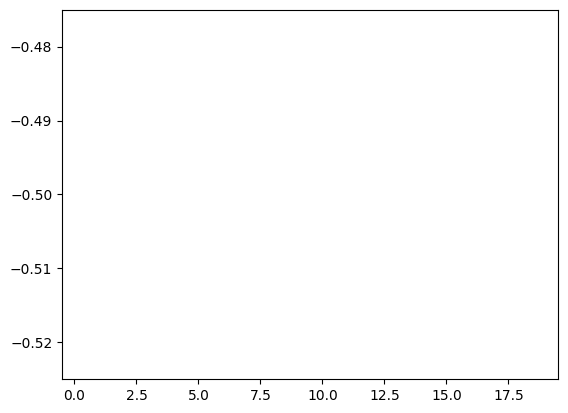

exploring grid: v2 w/ ghost DirectionalGhost_{"index":1,"prob":0.3}, noise-no_noise


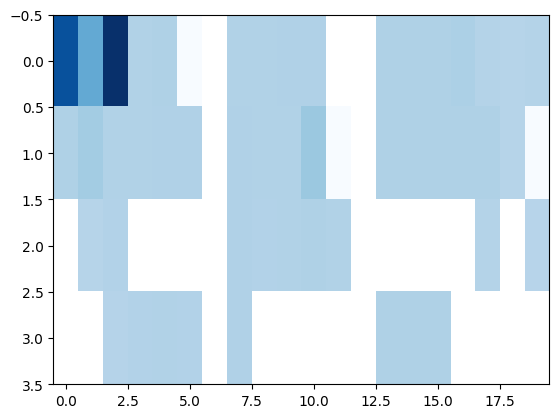

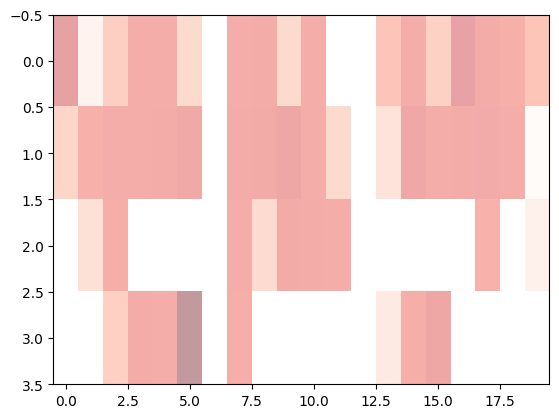

         0          1          2         3         4          5    6    \
0  33.609005  55.821739  70.752783 -0.341310  0.537895   0.000000  NaN   
1  22.651671   5.140190  -0.620756 -0.377107 -0.469576  -2.626064  NaN   
2        NaN  27.091325   0.055007       NaN       NaN        NaN  NaN   
3        NaN        NaN  17.921487 -0.804947 -0.225648 -26.262131  NaN   

        7          8          9    ...  975  976  977  978  979  980  981  \
0 -0.320395  -0.517870  24.622439  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1 -0.233188  -1.189433  -3.681376  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2 -0.035062  24.814552  -1.426578  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  0.675645        NaN        NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   982  983  984  
0  NaN  NaN  NaN  
1  NaN  NaN  NaN  
2  NaN  NaN  NaN  
3  NaN  NaN  NaN  

[4 rows x 985 columns]


/tmp/ipykernel_18158/4271188735.py:18: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



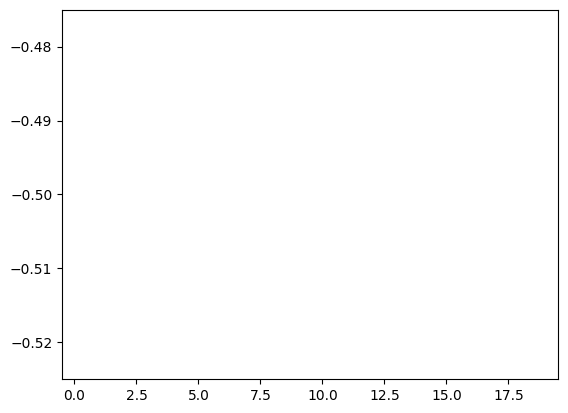

exploring grid: v3 w/ ghost DirectionalGhost_{"index":1,"prob":0.6}, noise-no_noise


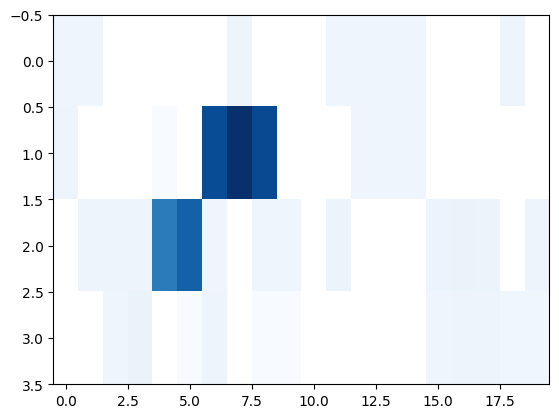

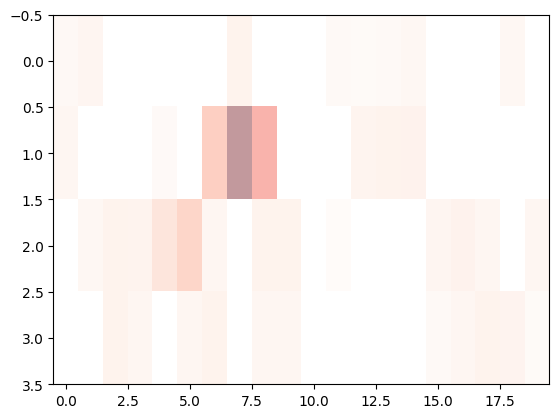

         0          1         2          3           4           5    \
0  35.821352  18.503537       NaN        NaN         NaN         NaN   
1  25.661353        NaN       NaN        NaN   23.747862         NaN   
2        NaN  31.305144  3.190242   4.722194  298.113543  292.507596   
3        NaN        NaN  0.965093  34.888514         NaN   -0.053597   

          6          7           8         9    ...  461  462  463  464  465  \
0         NaN   0.097500         NaN       NaN  ...  NaN  NaN  NaN  NaN  NaN   
1  309.073248  80.158442  219.806493       NaN  ...  NaN  NaN  NaN  NaN  NaN   
2   25.122006        NaN   -0.053156 -0.927629  ...  NaN  NaN  NaN  NaN  NaN   
3   -0.092828        NaN    0.047500  0.000000  ...  NaN  NaN  NaN  NaN  NaN   

   466  467  468  469  470  
0  NaN  NaN  NaN  NaN  NaN  
1  NaN  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN  
3  NaN  NaN  NaN  NaN  NaN  

[4 rows x 471 columns]


/tmp/ipykernel_18158/4271188735.py:18: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



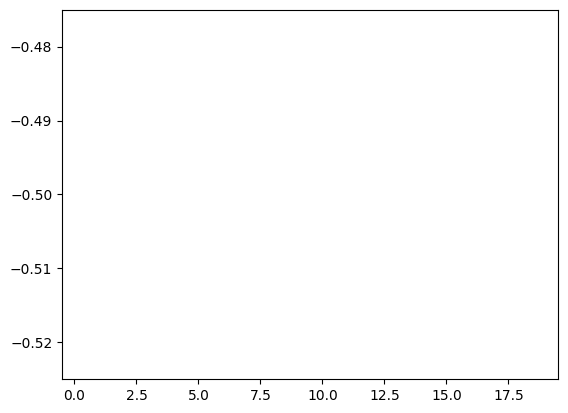

exploring grid: v3 w/ ghost DirectionalGhost_{"index":1,"prob":0.3}, noise-no_noise


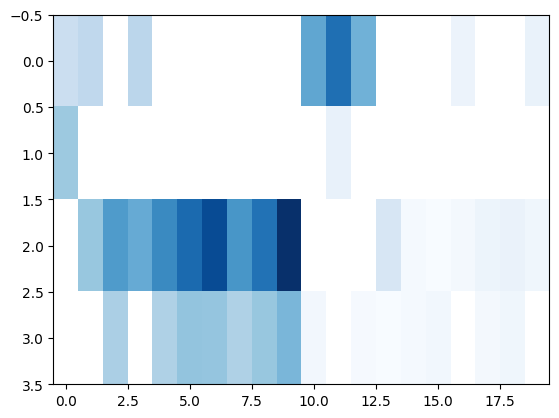

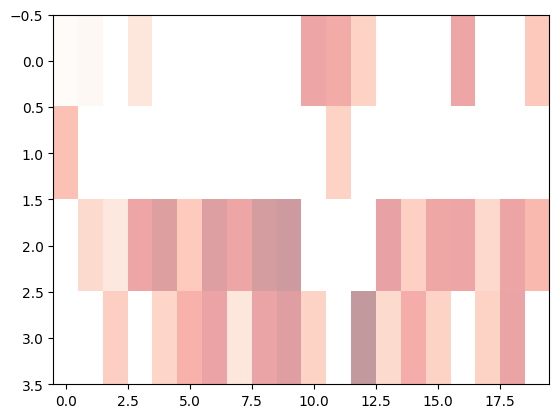

         0          1          2          3          4          5         6    \
0  49.867716  47.784495        NaN  35.228905        NaN        NaN       NaN   
1  15.757186        NaN        NaN        NaN        NaN        NaN       NaN   
2        NaN  29.447113  40.103596   2.956996  -4.052976  26.342613 -0.706386   
3        NaN        NaN  22.533034        NaN  26.026164   8.743435  0.061215   

         7         8         9    ...  472  473  474  475  476  477  478  479  \
0        NaN       NaN       NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1        NaN       NaN       NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2   4.203875 -6.746112 -5.950782  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  35.122447  0.166018 -6.183892  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   480  481  
0  NaN  NaN  
1  NaN  NaN  
2  NaN  NaN  
3  NaN  NaN  

[4 rows x 482 columns]


/tmp/ipykernel_18158/4271188735.py:18: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



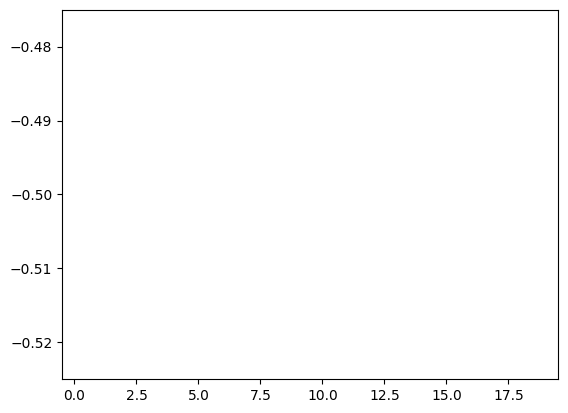

exploring grid: v3 w/ ghost RandomGhost_{"index":1,"prob":{}}, noise-no_noise


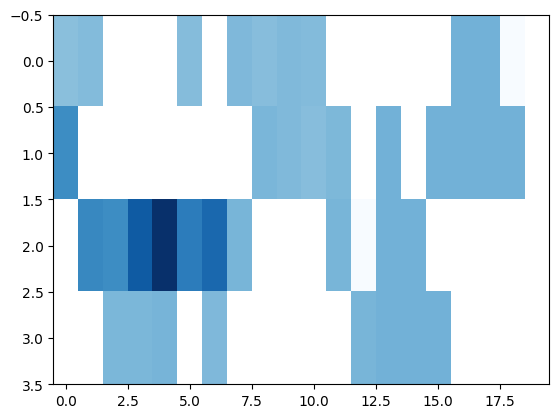

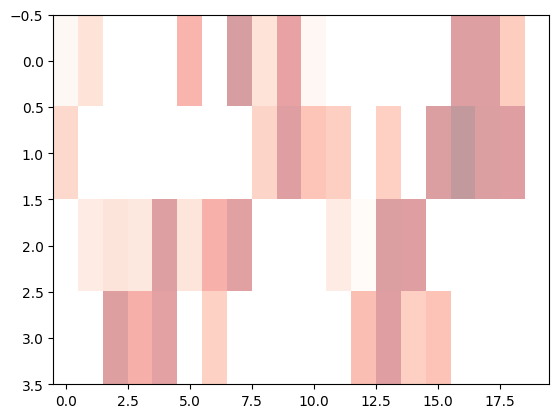

         0          1          2         3          4          5          6    \
0  41.545072  30.466506        NaN       NaN        NaN  12.181755        NaN   
1  37.276763        NaN        NaN       NaN        NaN        NaN        NaN   
2        NaN  46.184765  41.817209  53.65081  27.211619  45.368201  28.483719   
3        NaN        NaN  -0.583823  11.18829   2.787036        NaN  24.166947   

        7          8         9    ...  470  471  472  473  474  475  476  477  \
0 -3.290868  30.112070  3.876233  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1       NaN  26.050034 -0.549773  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  1.317427        NaN       NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3       NaN        NaN       NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   478  479  
0  NaN  NaN  
1  NaN  NaN  
2  NaN  NaN  
3  NaN  NaN  

[4 rows x 480 columns]


/tmp/ipykernel_18158/4271188735.py:18: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



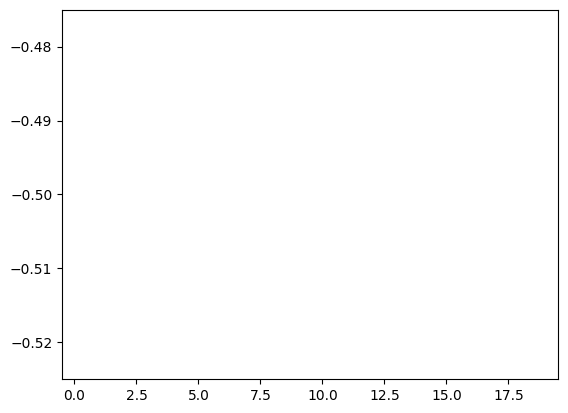

exploring grid: v4 w/ ghost DirectionalGhost_{"index":1,"prob":0.3}, noise-no_noise


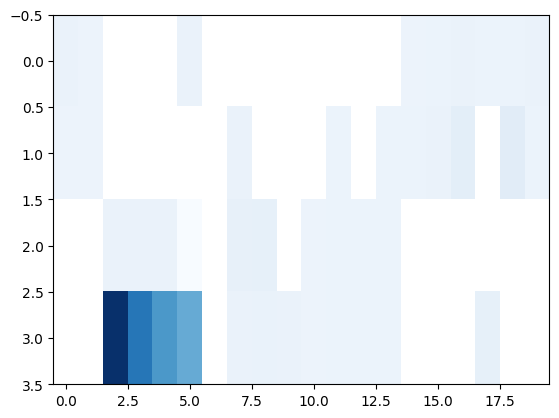

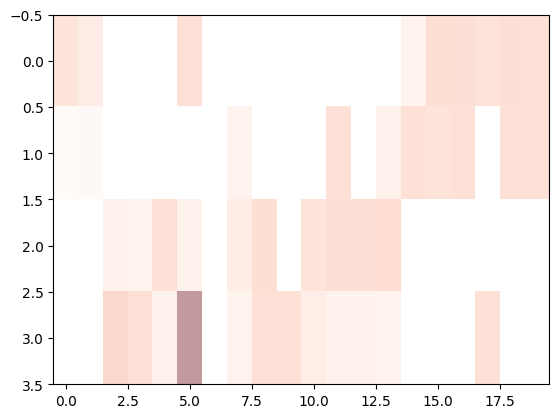

         0          1           2           3           4          5    6    \
0   4.672217  14.395077         NaN         NaN         NaN  -0.139247  NaN   
1  42.957863  39.057720         NaN         NaN         NaN        NaN  NaN   
2        NaN        NaN   24.749958   24.832350   -0.485368   0.000000  NaN   
3        NaN        NaN  342.720748  250.883009  225.275216  47.274679  NaN   

         7         8         9    ...  620  621  622  623  624  625  626  627  \
0        NaN       NaN       NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  26.904852       NaN       NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  22.330438  4.386355       NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  25.109368  1.805253  0.431032  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   628  629  
0  NaN  NaN  
1  NaN  NaN  
2  NaN  NaN  
3  NaN  NaN  

[4 rows x 630 columns]


/tmp/ipykernel_18158/4271188735.py:18: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



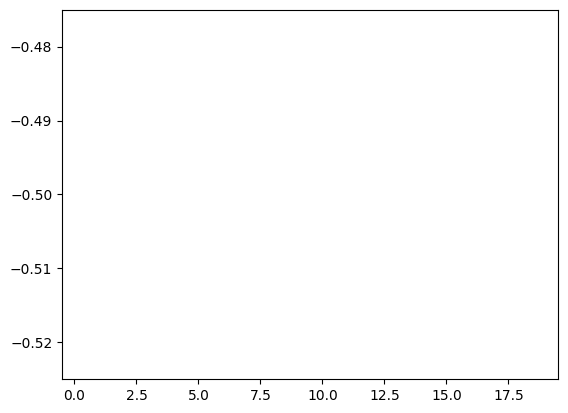

exploring grid: v4 w/ ghost RandomGhost_{"index":1,"prob":{}}, noise-no_noise


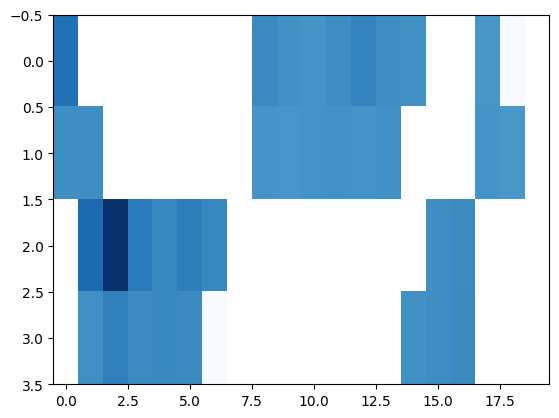

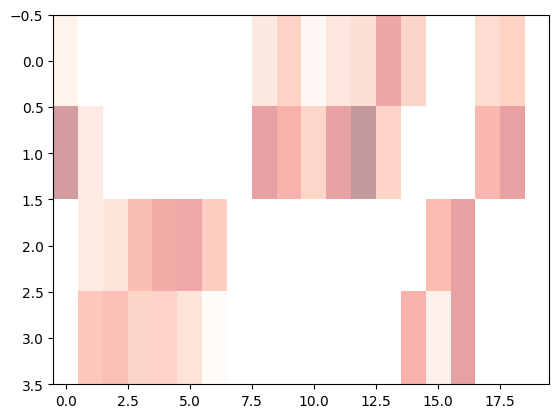

         0          1          2          3          4          5    \
0  43.993536        NaN        NaN        NaN        NaN        NaN   
1 -10.047450  35.298586        NaN        NaN        NaN        NaN   
2        NaN  40.467421  45.899284  16.042492   6.395032   5.397377   
3        NaN  17.193468  16.175478  24.933554  24.795262  31.921802   

         6    7          8          9    ...  626  627  628  629  630  631  \
0        NaN  NaN  34.711626  23.549985  ...  NaN  NaN  NaN  NaN  NaN  NaN   
1        NaN  NaN  -2.430226   7.596376  ...  NaN  NaN  NaN  NaN  NaN  NaN   
2  22.535017  NaN        NaN        NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   
3  23.797500  NaN        NaN        NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   

   632  633  634  635  
0  NaN  NaN  NaN  NaN  
1  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  
3  NaN  NaN  NaN  NaN  

[4 rows x 636 columns]


/tmp/ipykernel_18158/4271188735.py:18: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



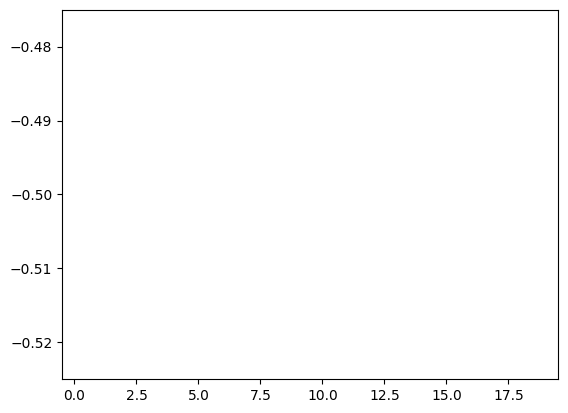

exploring grid: v4 w/ ghost DirectionalGhost_{"index":1,"prob":0.6}, noise-no_noise


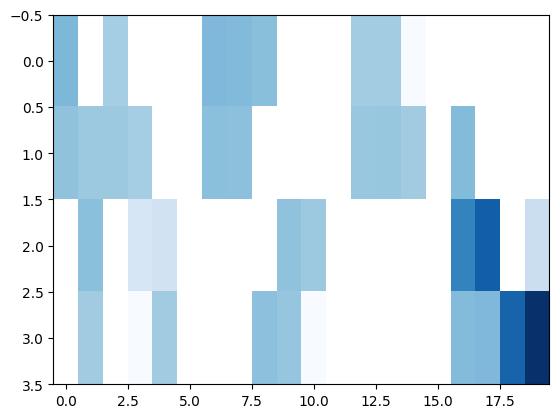

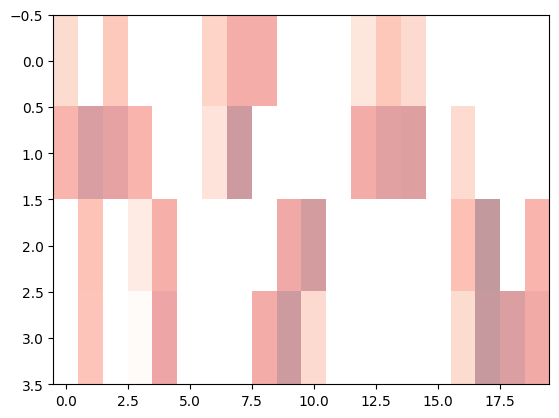

         0          1          2          3          4    5          6    \
0  49.383781        NaN  33.845645        NaN        NaN  NaN  44.716130   
1  26.541573   4.177117  11.745701  23.389945        NaN  NaN  51.461366   
2        NaN  34.256276        NaN  41.951998  11.889862  NaN        NaN   
3        NaN  32.276031        NaN  46.405125  15.043115  NaN        NaN   

         7          8          9    ...  620  621  622  623  624  625  626  \
0  24.074316  22.998585        NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1   2.184383        NaN        NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2        NaN        NaN  20.075196  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3        NaN  21.995963   1.341441  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   627  628  629  
0  NaN  NaN  NaN  
1  NaN  NaN  NaN  
2  NaN  NaN  NaN  
3  NaN  NaN  NaN  

[4 rows x 630 columns]


/tmp/ipykernel_18158/4271188735.py:18: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



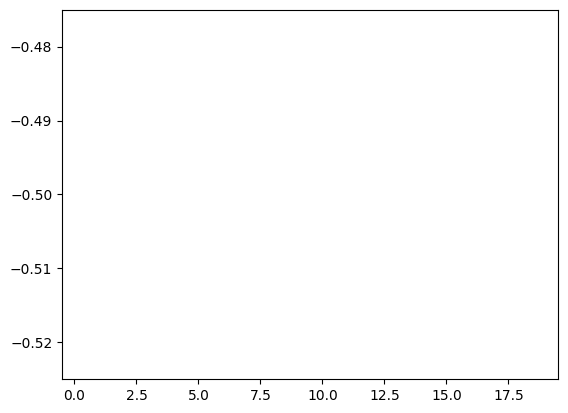

In [33]:
ax = plt.axes()
for grid in data.keys():
    for ghost in data[grid].keys():
        print(f"exploring grid: {grid} w/ ghost {ghost}, noise-no_noise")
        actions = len(pd.DataFrame(data[grid][ghost]).stack().apply(pd.Series).columns)
        action_pd_no_noise =pd.DataFrame(data[grid][ghost],index=name[grid][ghost]).T.filter(like='{"mean":0,"std":0}').T.stack().apply(pd.Series).T.iloc[["0","1","2","3"]]
        action_pd_no_noise.columns = action_pd_no_noise.columns.droplevel()
        actions = len(pd.DataFrame(data[grid][ghost]).stack().apply(pd.Series).columns)
        action_pd_noise = pd.DataFrame(data[grid][ghost],index=name[grid][ghost]).T.filter(like='{"mean":0,"std":0.1}').T.stack().apply(pd.Series).T.iloc[["0","1","2","3"]]
        action_pd_noise.columns = action_pd_noise.columns.droplevel()
        merge = pd.merge(action_pd_no_noise, action_pd_noise, how='outer')
        plt.imshow(merge.iloc[:4,:20], aspect="auto", cmap='Blues',alpha=1, interpolation='none') # I would add interpolation='none'
        plt.show()
        plt.imshow(merge.iloc[4:,:20], aspect="auto", cmap='Reds', alpha=0.4, interpolation='none')
        plt.show()
        diff = pd.DataFrame(merge.iloc[:4,].to_numpy() - merge.iloc[4:,].to_numpy())
        plt.imshow(diff.iloc[4:,:20], aspect="auto", cmap='binary')
        plt.show()

TypeError: Image data of dtype object cannot be converted to float

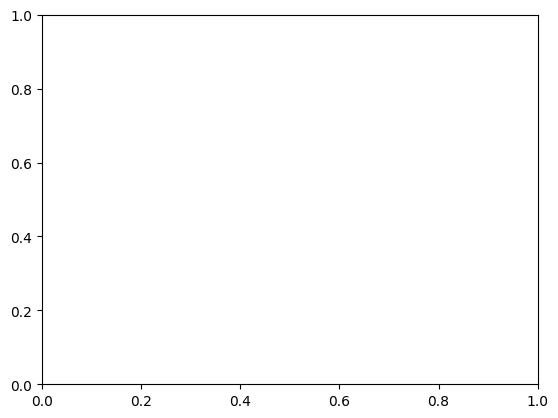

In [22]:
key='v2'
actions = len(pd.DataFrame(data[key]).stack().apply(pd.Series).columns)
action_pd_no_noise = pd.DataFrame(data[key]).stack().apply(pd.Series).xs(0, level=0).T.iloc[["0","1","2","3"]]
plt.imshow(action_pd_no_noise.iloc[:,:20], aspect="auto")

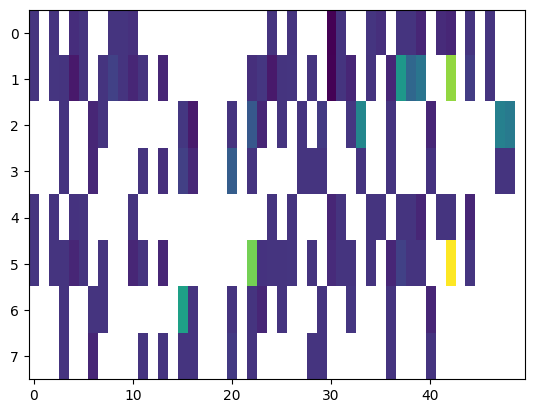

In [220]:
merge = pd.merge(action_pd_no_noise, action_pd_noise, how='outer')
plt.imshow(merge.iloc[:,-100:-50], aspect="auto")

In [187]:
for key in data:
    print(f"examining {key}")
    actions = len(pd.DataFrame(data[key]).stack().apply(pd.Series).columns)
    action_pd_noise = pd.DataFrame(data[key]).stack().apply(pd.Series).xs(1, level=0).T
    print(sum(sum(action_pd_noise.T[["0","1","2","3"]].T.isnull().to_numpy())))
    action_pd_no_noise = pd.DataFrame(data[key]).stack().apply(pd.Series).xs(0, level=0).T
    print(sum(sum(action_pd_no_noise.T[["0","1","2","3"]].T.isnull().to_numpy())))
    print(action_pd_noise.shape, action_pd_no_noise.shape)

examining v2
367
1086
(4, 331) (4, 969)
examining v3
821
1098
(4, 365) (4, 471)
examining v4


KeyError: 1

1086

(4, 331) (4, 969)


In [105]:
action_no_noise = pd.DataFrame(data["v2"]).stack().apply(pd.Series).xs(0, level=0).T
action_pd_noise = pd.DataFrame(data["v2"]).stack().apply(pd.Series).xs(1, level=0).T
merge_df = pd.merge(action_pd_no_noise, how="outer")
merge_df.head()

,%%%%%%%\n% P%\n%G .%\n% %\n% %\n%. %\n%%%%%%%,%%%%%%%\n% %\n% P%\n%G %\n% %\n%. %\n%%%%%%%,%%%%%%%\n% %\n% P %\n% G %\n% %\n%. %\n%%%%%%%,%%%%%%%\n% P %\n% G %\n% %\n% %\n%. %\n%%%%%%%,%%%%%%%\n% GP %\n% %\n% %\n% %\n%. %\n%%%%%%%,%%%%%%%\n% G %\n% %\n% %\n% %\n%. %\n%%%%%%%,%%%%%%%\n%G P %\n% .%\n% %\n% %\n%. %\n%%%%%%%,%%%%%%%\n% %\n% %\n% P %\n%G %\n%. %\n%%%%%%%,%%%%%%%\n% %\n% %\n%GP %\n% %\n%. %\n%%%%%%%,%%%%%%%\n% %\n% %\n%G %\n% %\n%. %\n%%%%%%%,...,%%%%%%%\n% %\n% P%\n% G %\n% %\n%. %\n%%%%%%%,%%%%%%%\n% %\n% .%\n% G%\n%P %\n%. %\n%%%%%%%,%%%%%%%\n% %\n% .%\n% P %\n% %\n%. G%\n%%%%%%%,%%%%%%%\n% P%\n% .%\n% %\n% %\n% G %\n%%%%%%%,%%%%%%%\n% %\n%G %\n% %\n% %\n%P %\n%%%%%%%,%%%%%%%\n% P %\n% .%\n% %\n% %\n% G %\n%%%%%%%,%%%%%%%\n% %\n% G .%\n% %\n% %\n%P %\n%%%%%%%,%%%%%%%\n% G %\n% %\n% %\n% %\n%P %\n%%%%%%%,%%%%%%%\n% G P%\n% .%\n% %\n% %\n% %\n%%%%%%%,%%%%%%%\n% %\n% .%\n% %\n% P %\n% G%\n%%%%%%%
0,109.852707,-0.964177,122.001150,4.481890,2.185241,NaN,-0.050000,11.668361,1.731374,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.097500,71.961955,-0.444624,-0.771629,-25.050000,NaN,0.000000,-0.086758,-25.050000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,-1.141752,-0.462592,NaN,NaN,NaN,NaN,-0.050000,-0.145463,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,-0.458734,-0.766429,-0.778150,NaN,-0.050000,-0.088585,-0.050000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-47.193796,0.338720,2.269786,-0.310193,-0.838705,NaN,2.373999,0.000000,-0.050000,NaN,...,NaN,0.45,0.0,72.596125,NaN,-0.000714,NaN,NaN,0.0,0.0


In [70]:
col_1 = list(action_0_pd_noise.keys())
col_2 = []
corr, fig_corr, p, fig_p, fig_r2 = correlation(action_0_pd_noise)

TypeError: 'float' object is not subscriptable

In [ ]:
y_s = info_n_robert_base.iloc[:,1:22]
X = info_n_robert_base.iloc[:,22:]
col_1 = ['0_x']
col_2 = list(y_s.keys())
corr, fig_corr, p, fig_p, fig_r2 = correlation(corr_matrix_df)

In [ ]:
pd.DataFrame(data["v2"]).stack().apply(pd.Series).xs(1, level=0).T